#### Imports

In [1]:
%matplotlib inline
%matplotlib widget
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

from PIL import Image

from mobilenet.mobilenetv3 import MobileNetV3

#### Variables

In [2]:
train_data_path = 'data/train/'
test_data_path = 'data/test/'
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 224
IN_CHANNELS = 3

#### Data loading

In [3]:
# Transforms
train_transforms = transforms.Compose([# transforms.RandomRotation(30),
                                       transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                    ])

# round(IMG_SIZE*1.1428571428571428571428571428571)
test_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      # transforms.CenterCrop(IMG_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                    ])

# Datasets reading and splitting
initial_train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transforms)
train_size = round(0.85 * len(initial_train_dataset))
validation_size = len(initial_train_dataset) - train_size

train_dataset, validation_dataset = random_split(initial_train_dataset, [train_size, validation_size])
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)


# Dataloaders
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE//2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE//2, shuffle=False)

#### Model loading

In [4]:
model = MobileNetV3(3, 2)
print(model.classifier)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=train_size//BATCH_SIZE, gamma=0.9)
criterion = nn.CrossEntropyLoss()

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): HSwish(
    (relu6): ReLU6(inplace=True)
  )
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1280, out_features=2, bias=True)
)


#### Test function

In [5]:
def test(model: nn.Module, criterion: object):
    model.eval()
    
    with torch.no_grad():
        loss = 0
        correct = 0
        total_data = 0
        
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss += criterion(output, labels).item()
            
            equals = labels == output.argmax(dim=1)  # Creates a list e.g. in this form: [True, True, False, True, False]
            correct += sum(equals).item()  # number of True values in the tensor, using item() to change from tensor to python integer
            total_data += len(labels)
        
        test_loss = loss / len(test_dataloader)
        test_accuracy = correct / total_data
        
        return test_loss, test_accuracy

#### Validation function

In [6]:
def validation(model: nn.Module, criterion: object):
    model.eval()
    
    with torch.no_grad():
        loss = 0
        correct = 0
        total_data = 0
        
        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss += criterion(output, labels).item()
            
            equals = labels == output.argmax(dim=1)  # Creates a list e.g. in this form: [True, True, False, True, False]
            correct += sum(equals).item()  # number of True values in the tensor, using item() to change from tensor to python integer
            total_data += len(labels)
        
        validation_loss = loss / len(validation_dataloader)
        validation_accuracy = correct / total_data
        
        return validation_loss, validation_accuracy

#### Train function

In [7]:
def train(model: nn.Module, epochs: int, optimizer: optim.Optimizer, criterion: object):
    model.to(device)
    best_val_loss = 100000

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
    
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

        validation_loss, validation_accuracy = validation(model, criterion)
        
        print(f'[ EPOCH ]                 {epoch+1:3d}\n'
              f'[ Train Loss ]            {running_loss/len(train_dataloader):.4f}\n'
              f'[ Validation Loss ]       {validation_loss:.4f}\n'
              f'[ Validation Accuracy ]   {validation_accuracy:.4f}\n'
              '---------------------------------\n',
        )

        # Save the model with the best (lowest) Validation Loss
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save(model.state_dict, 'MBNetV3_Hotdog_classifier.pt')
            

#### Train and Validate

In [8]:
train(model, epochs=20, optimizer=optimizer, criterion=criterion)

[ EPOCH ]                   1
[ Train Loss ]            0.6756
[ Validation Loss ]       0.8210
[ Validation Accuracy ]   0.6730
---------------------------------

[ EPOCH ]                   2
[ Train Loss ]            0.6204
[ Validation Loss ]       0.6152
[ Validation Accuracy ]   0.6903
---------------------------------

[ EPOCH ]                   3
[ Train Loss ]            0.6054
[ Validation Loss ]       0.5966
[ Validation Accuracy ]   0.6903
---------------------------------

[ EPOCH ]                   4
[ Train Loss ]            0.5903
[ Validation Loss ]       0.5943
[ Validation Accuracy ]   0.7044
---------------------------------

[ EPOCH ]                   5
[ Train Loss ]            0.5680
[ Validation Loss ]       0.5500
[ Validation Accuracy ]   0.7421
---------------------------------

[ EPOCH ]                   6
[ Train Loss ]            0.5331
[ Validation Loss ]       0.5099
[ Validation Accuracy ]   0.7594
---------------------------------

[ EPOCH ]       

#### Test

In [9]:
test_loss, test_accuracy = test(model, criterion)

print(f'[ Test Loss ]       {test_loss:.4f}\n'
      f'[ Test Accuracy ]   {test_accuracy:.4f}\n'
      '---------------------------------')

[ Test Loss ]       0.7614
[ Test Accuracy ]   0.7200
---------------------------------


#### Inference helper functions

In [10]:
def preprocess_image(image_path):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns a Numpy array.
    """

    # Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image


def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


def predict(image_path, model):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    """
    
    image = preprocess_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model(image)
    
    # Convert to lists
    output = output.detach().type(torch.FloatTensor).numpy().tolist()[0]
    
    return output

#### Load test images

In [11]:
test_images_path = 'data/test/hotdog'
images_names = os.listdir(test_images_path)

images = [os.path.join(test_images_path, img) for img in images_names]

#### Random Inference from Test Images

Hotdog


<AxesSubplot:>

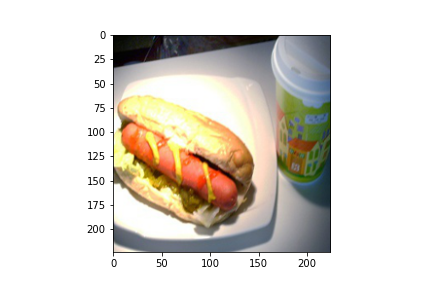

In [12]:
# define classes names
classes = {
    0: 'Hotdog',
    1: 'Not Hotdog',
}

# take a random image's index
img_to_test = np.random.randint(0, len(images))

# get model's output
model.eval()
with torch.no_grad():
    print(classes[np.argmax(predict(images[img_to_test], model))])

# show the image for visual validation
imshow(preprocess_image(images[img_to_test]))